#### Challenge 1   
  
- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it and ensure there is a column for each feature (C/A, UNIT, SCP, STATION). These are the first four columns.

#### Answer

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'png'
# this statement allows the visuals to render within your Jupyter Notebook

%matplotlib inline
# plt.rcParams['figure.dpi']= 300

In [2]:
def mta_end_of_week(d):
    ''' Calculates the end of the week for a given date to conform to MTA data publication on Saturday
        
        d = date vaule
        return: date 
    '''
    return d - timedelta(days=d.weekday()) + timedelta(days=5)

def read_mta_turnstile(start='20180501', end='20180531'):
    ''' Read MTA turnstile data. Calculates 4-hour bucket entries and exits for each (C/A, UNIT, SCP, STATION)
    start = start date for analysis in yyymmdd format
    end = end date for analysis in yyymmmdd format
    return pd.DataFrame (same list of columns as in the MTA CSV +
                        [date_time, entries_offset, exits_offset, hourly_entries, hourly_exits])
    '''
    first = mta_end_of_week(datetime.strptime(start, '%Y%m%d').date())
    last = mta_end_of_week(datetime.strptime(end, '%Y%m%d').date())
    
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    
    df = pd.DataFrame(columns=['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS'])
    while first <= last:
        data_file = url + datetime.strftime(first,'%y%m%d') + '.txt'
        print('Reading:', data_file)
        df = df.append(pd.read_csv(data_file), sort=False)
        first = first + timedelta(weeks=1)
    
    # fix some weird column thing where EXISTS is name with whitespace
    df.iloc[:,10] = df.iloc[:,11]
    df = df.iloc[:,:11]
    df.rename(columns={'C/A':'CA'}, inplace=True) # rename column for easier (dot) access

    # group df into (CA, UNIT, SCP, STATION)
    df['date_time'] = pd.to_datetime(df.DATE + ' ' + df.TIME, format='%m/%d/%Y %H:%M:%S')
    df['hour'] = df.date_time.dt.hour
    df.sort_values(by=['STATION','CA','UNIT','SCP','date_time'], inplace=True)
    df['entries_offset'] = df.groupby(['CA','UNIT','SCP','STATION'])['ENTRIES'].shift(-1) # get everything one row down and shift up
    df['exits_offset'] = df.groupby(['CA','UNIT','SCP','STATION'])['EXITS'].shift(-1)
    df['hourly_entries'] = df.entries_offset - df.ENTRIES
    df['hourly_exits'] = df.exits_offset - df.EXITS

    # set all hourly entires < 0 to negative and anything bigger than 100,000 as np.nan
    df.loc[df.hourly_entries < 0,'hourly_entries'] = np.nan
    df.loc[df.hourly_exits < 0,'hourly_exits'] = np.nan
    df.loc[df.hourly_entries > 100000,'hourly_entries'] = np.nan
    df.loc[df.hourly_exits > 100000,'hourly_exits'] = np.nan

    # set entries data to floats
    df.hourly_entries = df.hourly_entries.astype(float)
    df.hourly_exits = df.hourly_exits.astype(float)
    
    # reset the indicies as they repeat for each download
    df.reset_index(inplace=True)
    return df

mta = read_mta_turnstile()
mta.sample(5)

Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180505.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180512.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180519.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180526.txt
Reading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180602.txt


,index,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,hour,entries_offset,exits_offset,hourly_entries,hourly_exits
578022,63774,N128,R200,00-00-00,EUCLID AV,AC,IND,05/27/2018,12:00:00,REGULAR,372558,109683.0,2018-05-27 12:00:00,12,372677,109724.0,119.0,41.0
602823,162165,R289,R119,00-05-01,FORDHAM RD,4,IRT,05/17/2018,04:00:00,REGULAR,100663296,16777562.0,2018-05-17 04:00:00,4,100663296,16777562.0,0.0,0.0
76429,70410,N207,R104,00-00-00,167 ST,BD,IND,05/08/2018,00:00:00,REGULAR,9204120,6852212.0,2018-05-08 00:00:00,0,9204131,6852263.0,11.0,51.0
756500,75166,N305,R017,01-03-00,LEXINGTON AV/53,EM6,IND,04/29/2018,16:00:00,REGULAR,1849616,950401.0,2018-04-29 16:00:00,16,1849679,950448.0,63.0,47.0
278256,46808,N051,R084,02-00-00,59 ST COLUMBUS,ABCD1,IND,05/29/2018,12:00:00,REGULAR,11546812,1455826.0,2018-05-29 12:00:00,12,11548182,1456073.0,1370.0,247.0


#### Challenge 2

- Let's turn this into a time series.

Create a new column that specifies the date and time of each entry.

You can convert the date and time into datetime objects
-- That is a python class that represents a point in time. You can
combine the date and time fields into a string and use the
[dateutil](https://labix.org/python-dateutil) module to convert it
into a datetime object. For an example check
[this StackOverflow question](http://stackoverflow.com/questions/23385003/attributeerror-when-using-import-dateutil-and-dateutil-parser-parse-but-no).

Also, check out this handy [Pandas function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html).

#### Answer
The conversion was done in the read function above. The code snippet is below.

In [3]:
# mta['date_time'] = pd.to_datetime(mta.DATE + ' ' + mta.TIME)
mta.loc[:,['DATE','TIME','date_time']].sample(5)    

,DATE,TIME,date_time
551256,05/07/2018,20:00:00,2018-05-07 20:00:00
467516,05/24/2018,16:00:00,2018-05-24 16:00:00
458855,05/15/2018,09:00:00,2018-05-15 09:00:00
812710,05/07/2018,11:49:55,2018-05-07 11:49:55
736589,05/05/2018,00:00:00,2018-05-05 00:00:00


#### Challenge 3

- These counts are for every n hours. (What is n?) We want total daily
  entries.
  
Calculate to total daily entries for each turnstile.

Your result should be a new data frame that has the same keys, but now we have a single
value for a single day, which is the total number of passengers that
entered through this turnstile on this day.

#### Answer

In [4]:
mta['next_date_time'] = mta.groupby(['CA','UNIT','SCP','STATION'])['date_time'].shift(-1)
mta['time_diff'] = mta.next_date_time - mta.date_time
mta.time_diff.describe()

count                    980682
mean     0 days 04:00:23.938317
std      0 days 00:39:49.305083
min             0 days 00:00:00
25%             0 days 04:00:00
50%             0 days 04:00:00
75%             0 days 04:00:00
max             9 days 19:44:57
Name: time_diff, dtype: object

In [5]:
mta[mta.time_diff == timedelta(0)][['CA','UNIT','SCP','STATION','date_time','next_date_time','time_diff','hourly_entries']]

,CA,UNIT,SCP,STATION,date_time,next_date_time,time_diff,hourly_entries
895510,R101,R001,02-00-00,SOUTH FERRY,2018-05-23 09:00:00,2018-05-23 09:00:00,0 days,0.0
895931,R101,R001,02-00-02,SOUTH FERRY,2018-05-23 09:00:00,2018-05-23 09:00:00,0 days,0.0
896562,R101,R001,02-00-05,SOUTH FERRY,2018-05-23 09:00:00,2018-05-23 09:00:00,0 days,0.0


In [6]:
(mta[mta.time_diff > timedelta(hours=4)]
 [['CA','UNIT','SCP','STATION','date_time','next_date_time','time_diff','hourly_entries']]
 .head(5)
)

,CA,UNIT,SCP,STATION,date_time,next_date_time,time_diff,hourly_entries
5326,R529,R208,00-00-00,103 ST-CORONA,2018-04-30 04:00:00,2018-04-30 12:00:00,08:00:00,1184.0
5537,R529,R208,00-00-01,103 ST-CORONA,2018-04-30 04:00:00,2018-04-30 12:00:00,08:00:00,1108.0
5748,R529,R208,00-00-02,103 ST-CORONA,2018-04-30 04:00:00,2018-04-30 12:00:00,08:00:00,1209.0
5855,R529,R208,00-00-02,103 ST-CORONA,2018-05-18 04:00:00,2018-05-18 12:00:00,08:00:00,1353.0
5958,R529,R208,00-00-03,103 ST-CORONA,2018-04-30 04:00:00,2018-04-30 12:00:00,08:00:00,1439.0


The majority of the turnstile observations are `n` = 4 hours, but some of the turnstiles are observed less frequently. The `mta_daily_entries` will aggregate the hourly_entries into daily buckets for each turnstile.

In [7]:
mta_daily_entries = mta.groupby(['CA','UNIT','SCP','STATION','DATE'])['hourly_entries'].sum().reset_index()
mta_daily_entries.DATE = pd.to_datetime(mta_daily_entries.DATE, format='%m/%d/%Y')
mta_daily_entries.rename(columns={'hourly_entries':'daily_entries'}, inplace=True)
mta_daily_entries.sample(5)

,CA,UNIT,SCP,STATION,DATE,daily_entries
89670,N607,R025,01-00-02,JAMAICA CENTER,2018-05-06,85.0
1264,A011,R080,01-00-02,57 ST-7 AV,2018-05-02,1634.0
60233,N220,R155,01-00-03,KINGSBRIDGE RD,2018-05-30,588.0
134102,R262,R195,03-06-00,161/YANKEE STAD,2018-05-20,369.0
38702,N049,R084,01-00-02,59 ST COLUMBUS,2018-05-14,1801.0


#### Challenge 4

Now plot the daily time series for a turnstile.

#### Answer
Will plot the daily time series for the following turnstile.

* `CA` - R145
* `UNIT` - R032
* `SCP` - 00-00-02
* `STATION` - TIMES SQ-42 ST

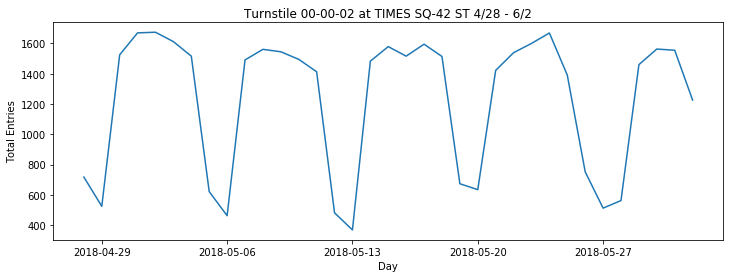

In [8]:
sub = ((mta_daily_entries.CA == 'R145')
      & (mta_daily_entries.UNIT == 'R032')
      & (mta_daily_entries.SCP == '00-00-02')
      & (mta_daily_entries.STATION == 'TIMES SQ-42 ST'))

x = mta_daily_entries.loc[sub, 'DATE']
y = mta_daily_entries.loc[sub,'daily_entries']
plt.figure(figsize=(12,4))
plt.plot(x,y)
plt.xlabel('Day')
plt.ylabel('Total Entries')
plt.title('Turnstile 00-00-02 at TIMES SQ-42 ST 4/28 - 6/2');

#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.

#### Answer

In [9]:
mta_daily_unit_stations = mta_daily_entries.groupby(['CA','UNIT','STATION','DATE'])['daily_entries'].sum().reset_index()
mta_daily_unit_stations.sample(5)

,CA,UNIT,STATION,DATE,daily_entries
3785,E009,R370,71 ST,2018-05-03,6214.0
14025,N544,R289,FT HAMILTON PKY,2018-05-21,3797.0
148,A011,R080,57 ST-7 AV,2018-05-06,6909.0
19559,R237B,R047,GRD CNTRL-42 ST,2018-05-29,12685.0
15064,N702,R572,96 ST-2 AVE,2018-05-10,11846.0


#### Challenge 6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.

#### Answer

In [10]:
mta_daily_stations = mta_daily_unit_stations.groupby(['STATION','DATE'])['daily_entries'].sum().reset_index()
mta_daily_stations.sample(5)

,STATION,DATE,daily_entries
9139,KINGSTON AV,2018-05-02,4865.0
8914,JKSN HT-ROOSVLT,2018-05-22,49996.0
9199,KINGSTON-THROOP,2018-05-27,3052.0
4748,BAY RIDGE AV,2018-05-21,7495.0
4990,BEACH 60 ST,2018-05-18,2413.0


#### Challenge 7

Plot the time series (either daily or your preferred level of granularity) for a station.

#### Answer
Plot of the TIMES SQ-42 ST station.

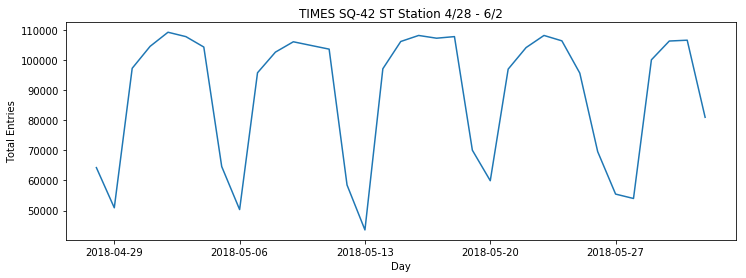

In [11]:
x = mta_daily_stations[mta_daily_stations.STATION == 'TIMES SQ-42 ST']['DATE']
y = mta_daily_stations[mta_daily_stations.STATION == 'TIMES SQ-42 ST']['daily_entries']

plt.figure(figsize=(12,4))
plt.plot(x,y)
plt.xlabel('Day')
plt.ylabel('Total Entries')
plt.title('TIMES SQ-42 ST Station 4/28 - 6/2');

#### Challenge 8

Select a station and find the total daily counts for this station. Then plot those daily counts for each week separately.

To clarify: if I have 10 weeks of data on the 28th st 6 station, I will add 10 lines to the same figure (e.g. running `plt.plot(week_count_list)` once for each week). Each plot will have 7 points of data.

#### Answer

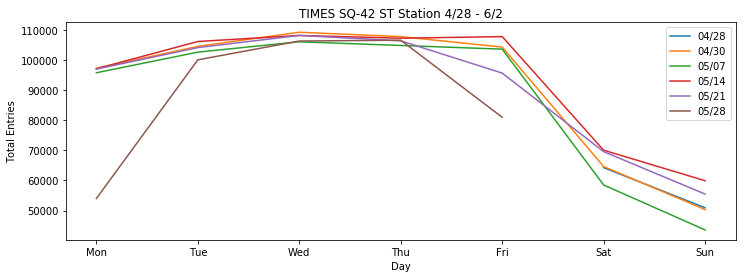

In [12]:
import calendar as c

mta_daily_stations['week'] = mta_daily_stations.DATE.dt.week
mta_daily_stations['day_of_week'] = mta_daily_stations.DATE.dt.dayofweek

plt.figure(figsize=(12,4))

l_lables = []
x_labels = list(c.day_abbr)

for week in range(mta_daily_stations.week.min(), mta_daily_stations.week.max()+1):
    x = (mta_daily_stations[(mta_daily_stations.STATION == 'TIMES SQ-42 ST') 
                            & (mta_daily_stations.week == week)]
                            ['day_of_week'])
    y = (mta_daily_stations[(mta_daily_stations.STATION == 'TIMES SQ-42 ST') 
                            & (mta_daily_stations.week == week)]
                             ['daily_entries'])
    (l_lables.append(mta_daily_stations[(mta_daily_stations.STATION == 'TIMES SQ-42 ST') 
                                        & (mta_daily_stations.week == week)]['DATE'].min().strftime('%m/%d')))
    plt.plot(x,y)

plt.xlabel('Day')
plt.ylabel('Total Entries')
plt.title('TIMES SQ-42 ST Station 4/28 - 6/2')
plt.legend(loc='best', labels = l_lables)
plt.xticks(range(0,7),x_labels);

#### Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate
  
#### Answer

In [13]:
mta_stations_agg = mta_daily_stations.groupby('STATION')['daily_entries'].sum().reset_index()
mta_stations_agg.sort_values('daily_entries',ascending=False,inplace=True)
mta_stations_agg.head(10)

,STATION,daily_entries
59,34 ST-PENN STA,4954922.0
230,GRD CNTRL-42 ST,4257536.0
57,34 ST-HERALD SQ,3399085.0
45,23 ST,3384815.0
14,14 ST-UNION SQ,3302879.0
350,TIMES SQ-42 ST,3111301.0
223,FULTON ST,2891149.0
65,42 ST-PORT AUTH,2866049.0
107,86 ST,2632104.0
9,125 ST,2342694.0


#### Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

#### Answer

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


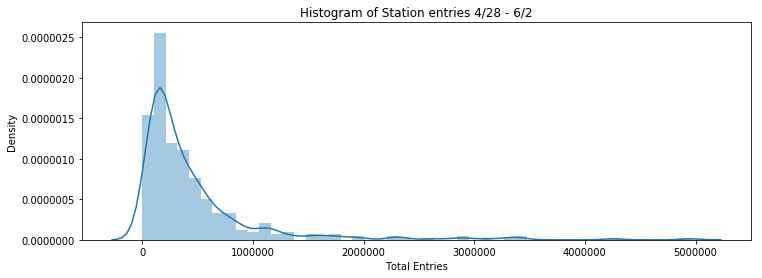

In [14]:
plt.figure(figsize=(12,4))

sns.distplot(mta_stations_agg.daily_entries)
plt.title('Histogram of Station entries 4/28 - 6/2')
plt.xlabel('Total Entries')
plt.ylabel('Density');